In [1]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

In [2]:
dataset_path = "tensorflow/dataset"
os.listdir(dataset_path)

['drowsy', 'nondrowsy']

In [3]:
print('drowsy  :',len(os.listdir("tensorflow/dataset/drowsy")))
print('nondrowsy :',len(os.listdir("tensorflow/dataset/nondrowsy")))

drowsy  : 250
nondrowsy : 250


In [4]:
# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        data.append(image)
        labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

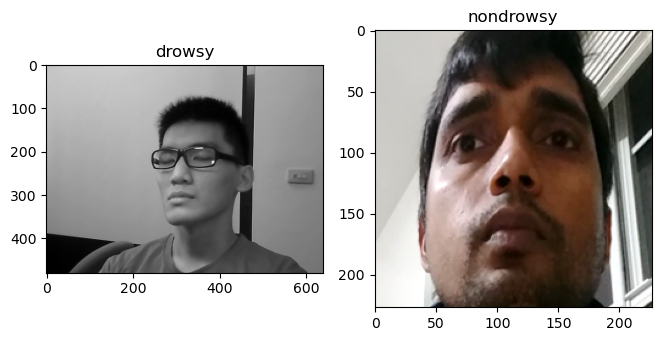

In [5]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "drowsy"))
grade2_images = os.listdir(os.path.join(dataset_path, "nondrowsy"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "drowsy", sample_grade1)
sample2_path = os.path.join(dataset_path, "nondrowsy", sample_grade2)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("drowsy")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("nondrowsy")

plt.tight_layout()
plt.show()


In [6]:
class_names = label_encoder.classes_

In [7]:
# Display the class names
print("Class Names:", class_names)

Class Names: ['drowsy' 'nondrowsy']


In [8]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [10]:
# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalize pixel values
)

In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

In [12]:
# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [13]:
# Load MobileNet base model (excluding top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

C:\Users\Tobias\AppData\Local\Temp\ipykernel_25644\1416666862.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [14]:
# Expansion Bottleneck Function
def expansion_bottleneck(input_tensor, filters, expansion_factor=6):
    # Expansion layer
    expanded_filters = filters * expansion_factor
    x = layers.Conv2D(expanded_filters, 1, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Depthwise convolution
    x = layers.DepthwiseConv2D(3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Projection layer
    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Skip connection if input and output shapes match
    if input_tensor.shape[-1] == filters:
        x = layers.Add()([x, input_tensor])
    
    return x


In [15]:
# Build the hybrid model
inputs = layers.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)

In [16]:
# Add expansion bottleneck blocks
x = expansion_bottleneck(x, filters=128)
x = layers.MaxPooling2D(2)(x)
x = expansion_bottleneck(x, filters=64)
x = layers.MaxPooling2D(2)(x)

In [17]:
# Final layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(130, activation='relu')(x)
x = layers.Dropout(0.55)(x)
outputs = layers.Dense(2, activation='softmax')(x)

hybrid_model = models.Model(inputs, outputs)

In [18]:
# Compile the model
hybrid_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [19]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=3)
]

In [20]:
# Train the model
history = hybrid_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

C:\Users\Tobias\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - accuracy: 0.5811 - loss: 0.8108 - val_accuracy: 0.5400 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.7935 - loss: 0.4281 - val_accuracy: 0.5400 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.9140 - loss: 0.2398 - val_accuracy: 0.5400 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.9481 - loss: 0.1715 - val_accuracy: 0.5400 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - accuracy: 0.9269 - loss: 0.1885 - val_accuracy: 0.5400 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.9325 - loss: 0.1334 - val_accuracy: 0.5400 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.9643 - loss: 0.1101 -

In [21]:
# Evaluation
val_loss, val_acc = hybrid_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9960 - loss: 0.2919
Validation Accuracy: 99.00%


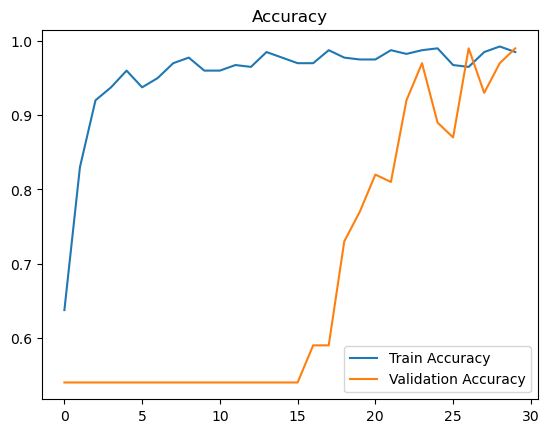

In [22]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

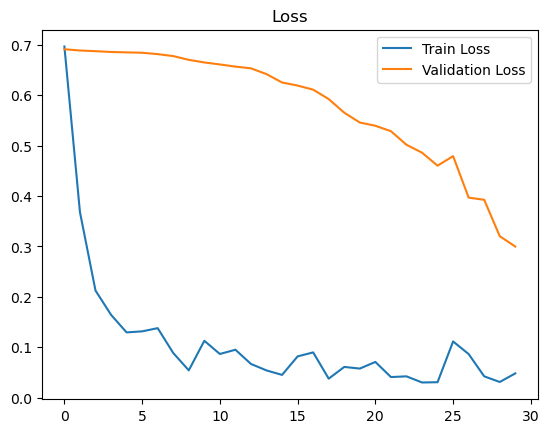

In [23]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the test data (same as training)
X_test = X_test / 255.0

# Make predictions
y_pred = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step


In [25]:
# Convert one-hot encoded y_test back to class indices if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test  # If already in class index format

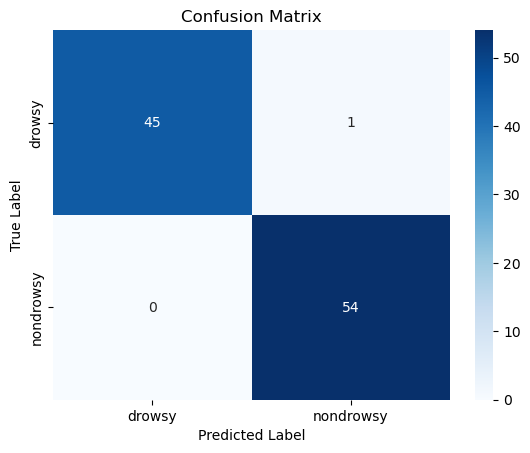

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      drowsy       1.00      0.98      0.99        46
   nondrowsy       0.98      1.00      0.99        54

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [28]:
import time
import os
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_model_metrics(model, input_shape=(1, 150, 150, 3)):
    """
    Menghitung Params, Size, FLOPs, dan Latency.
    """
    print("\n--- Calculating Model Metrics ---")
    
    # 1. Total Parameters
    total_params = model.count_params()
    
    # 2. Model Size (MB)
    # Kita simpan sementara ke file .h5 untuk mendapatkan ukuran asli di disk
    temp_filename = "temp_model_metrics.h5"
    model.save(temp_filename)
    size_bytes = os.path.getsize(temp_filename)
    model_size_mb = size_bytes / (1024 * 1024)
    os.remove(temp_filename) # Hapus file temp
    
    # 3. FLOPs (Floating Point Operations)
    # Mengubah model Keras menjadi Frozen Graph untuk profil yang akurat
    try:
        full_model = tf.function(lambda x: model(x))
        concrete_func = full_model.get_concrete_function(
            tf.TensorSpec(input_shape, model.inputs[0].dtype))
        
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        frozen_func.graph.as_graph_def()
        
        # Menggunakan TF Profiler untuk menghitung FLOPs
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
        # Karena TF 2.x, kita gunakan graph dari frozen function
        flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                              run_meta=run_meta, cmd='op', options=opts)
        total_flops = flops.total_float_ops
    except Exception as e:
        print(f"Gagal menghitung FLOPs secara otomatis: {e}")
        total_flops = 0

    # 4. Latency (Inference Time)
    # Generate dummy data
    dummy_input = tf.random.normal(input_shape)
    
    # Warmup (penting untuk GPU/CPU agar siap)
    for _ in range(10):
        _ = model(dummy_input)
        
    # Pengukuran Latency (Rata-rata dari 100 kali run)
    iterations = 100
    start_time = time.time()
    for _ in range(iterations):
        _ = model(dummy_input)
    end_time = time.time()
    
    avg_latency_ms = ((end_time - start_time) / iterations) * 1000
    
    return total_params, total_flops, model_size_mb, avg_latency_ms

# --- EKSEKUSI FUNGSI DI ATAS ---
# Pastikan input shape sesuai dengan model Anda (1 batch, 150 height, 150 width, 3 channels)
params, flops, size_mb, latency = get_model_metrics(hybrid_model, input_shape=(1, 150, 150, 3))

print("\n" + "="*50)
print(f"Drowsy Model Metrics Results:")
print("="*50)
print(f"| {'Metric':<20} | {'Value':<20} |")
print(f"|{'-'*22}|{'-'*22}|")
print(f"| {'Params':<20} | {params:,.0f} parameters  |")
print(f"| {'FLOPs':<20} | {flops:,.0f} Ops       |")
print(f"| {'Model Size':<20} | {size_mb:.2f} MB          |")
print(f"| {'Latency':<20} | {latency:.4f} ms        |")
print("="*50 + "\n")

# Format untuk Tabel Laporan Anda
print("Data untuk Tabel:")
print(f"| MobileNetV2 + SE | {params} | {flops} | {size_mb:.2f} | {latency:.2f} |")


--- Calculating Model Metrics ---



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.



Drowsy Model Metrics Results:
| Metric               | Value                |
|----------------------|----------------------|
| Params               | 3,444,616 parameters  |
| FLOPs                | 354,567,062 Ops       |
| Model Size           | 22.59 MB          |
| Latency              | 207.2284 ms        |

Data untuk Tabel:
| MobileNetV2 + SE | 3444616 | 354567062 | 22.59 | 207.23 |
